In [62]:
ROOT = '/Users/longhoang/Developer/table-recognition/data/SciTSR/train'
IMG_NAME = '0705.0454v1.1'

In [63]:
import json
import os
import glob

import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import numpy as np
import cv2 as cv
from operator import itemgetter

In [75]:
IMG_PNG = os.path.join(ROOT, 'img', IMG_NAME + '.png')
IMG_PDF = os.path.join(ROOT, 'pdf', IMG_NAME + '.pdf')
IMG_CHUNK = os.path.join(ROOT, 'chunk', IMG_NAME + '.chunk')
IMG_STRUCT = os.path.join(ROOT, 'structure', IMG_NAME + '.json')
IMG_REL = os.path.join(ROOT, 'rel', IMG_NAME + '.rel')

In [65]:
def load_img(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"! ERROR !: Unable to read image from {img_path}")
        return None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def view_img(img):
    plt.figure(figsize=(7,7))
    if img.ndim == 3:
        if img.shape[-1] == 3:
            plt.imshow(img)
        else:
            plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

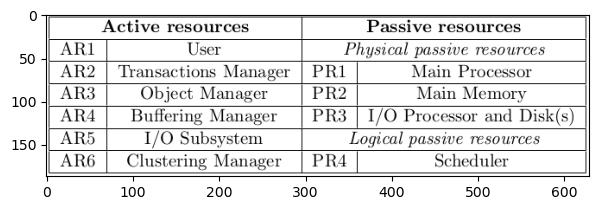

In [66]:
img = load_img(IMG_PNG)
view_img(img)

In [67]:
def get_table_pos(pdf_path, display=False):
    imgs_pdf = convert_from_path(pdf_path, 150)
    assert len(imgs_pdf) == 1, 'There is more than one pdf image'
    img_pdf = np.array(imgs_pdf[0])
    gray = cv.cvtColor(img_pdf, cv.COLOR_RGB2GRAY)
    thresh, gray = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    coords = cv.findNonZero(gray)
    x, y, w, h = cv.boundingRect(coords)
    left, top, right, bottom = x - 3, y - 3, x + w + 3, y + h + 3
    if display:
        top_left = (round(left), round(top))
        bottom_right = (round(right), round(bottom))
        cv.rectangle(img_pdf, top_left, bottom_right, (0, 0, 255), 3)
        view_img(img_pdf)
        print('Shape: ' + str(img_pdf.shape))
    return left, top, right, bottom

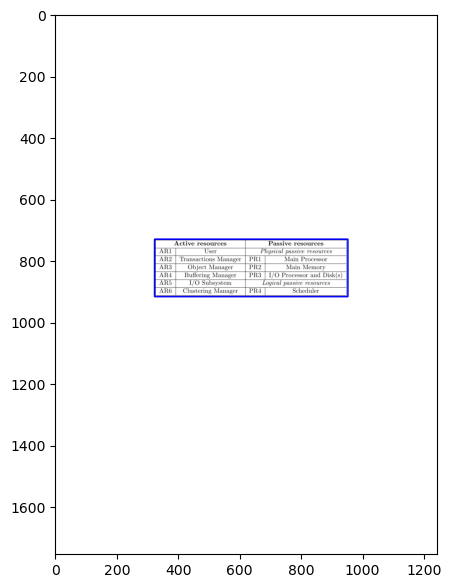

Shape: (1754, 1241, 3)
Top left: (729, 323)
Bottom right: (916, 951)


In [68]:
left, top, right, bottom = get_table_pos(IMG_PDF, display=True)
print(f'Top left: ({top}, {left})')
print(f'Bottom right: ({bottom}, {right})')

In [69]:
def coord_pdf2img(x, y, left, top):
    ratio = 1754 / 842
    new_x = x * ratio - left
    new_y = 1754 - y * ratio - top
    return new_x, new_y

def read_chunk(chunk_path, left, top, display=False):
    chunk_list = []
    with open(chunk_path) as f:
      data = json.load(f)
      chunks = data['chunks']
      #print(len(chunks))
      for c in chunks:
          pos = c['pos']
          l,r,t,b = int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])
          if display: print('OG       :', l,t,r,b, '--', c['text'])
          l,t = coord_pdf2img(l,t, left, top)
          r,b = coord_pdf2img(r,b, left, top)
          if display: print('Converted:', int(l), int(t), int(r), int(b))
          if t > b: t, b = b, t
          chunk_list.append((c['text'], [int(l), int(t), int(r), int(b)]))
    return chunk_list

OG       : 185 481 267 486 -- Activeresources
Converted: 62 23 233 12
OG       : 332 481 418 486 -- Passiveresources
Converted: 368 23 547 12
OG       : 162 469 182 474 -- AR1
Converted: 14 48 56 37
OG       : 232 469 252 474 -- User
Converted: 160 48 201 37
OG       : 319 469 431 474 -- Physicalpassiveresources
Converted: 341 48 574 37
OG       : 162 457 182 462 -- AR2
Converted: 14 73 56 62
OG       : 194 457 290 462 -- Transactions Manager
Converted: 81 73 281 62
OG       : 302 457 321 462 -- PR1
Converted: 306 73 345 62
OG       : 357 457 424 462 -- Main Processor
Converted: 420 73 560 62
OG       : 162 444 182 449 -- AR3
Converted: 14 100 56 89
OG       : 206 444 277 449 -- Object Manager
Converted: 106 100 254 89
OG       : 302 444 321 449 -- PR2
Converted: 306 100 345 89
OG       : 360 444 422 449 -- Main Memory
Converted: 426 100 556 89
OG       : 162 432 182 437 -- AR4
Converted: 14 125 56 114
OG       : 201 432 283 437 -- Buﬀering Manager
Converted: 95 125 266 114
OG       : 

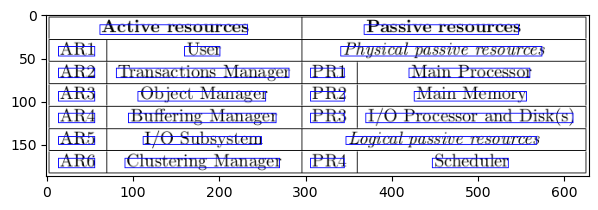

In [70]:
chunks = read_chunk(IMG_CHUNK, left, top, True)

img_draw = img.copy()

for chunk in chunks:
    pos = chunk[1]
    left_top = (pos[0], pos[1])
    bottom_right = (pos[2], pos[3])
    cv.rectangle(img_draw, left_top, bottom_right, (0, 0, 255), 1)

view_img(img_draw)

In [71]:
def read_cells(struct_path):
    Cells = []
    nRow, nCol = 0, 0
    with open(struct_path) as f:
        data = json.load(f)
        cells = data['cells']
        for c in cells:
            content = c['content']
            if content is None: continue
            id = c['id']
            sr, er = c['start_row'], c['end_row']
            sc, ec = c['start_col'], c['end_col']
            nRow = max(nRow, er+1)
            nCol = max(nCol, ec+1)
            Cells.append({'id': id, 'range': [sr, er, sc, ec], 'content': content})

    Cells = sorted(Cells, key=itemgetter('id'))

    return nRow, nCol, Cells

def update_cells(cells, chunks):
    ChunkSkip = 0
    for i, c in enumerate(cells):
        if c['content'] == [] or i - ChunkSkip >= len(chunks):
            cells[i].update({'pos': [0,0,0,0]})
            ChunkSkip += 1
        else:
            cells[i].update({'pos': chunks[i-ChunkSkip][1]})
        if c['range'][1] > c['range'][0]:
            cells[i].update({'flag': 1}) # flag 1 means rol-span cell
        elif c['range'][3] > c['range'][2]:
            cells[i].update({'flag': 2}) # flag 2 means col-span cell
        else:
            cells[i].update({'flag': 0}) # flag 0 means single cell
        #print(Cells)
        
    return cells  

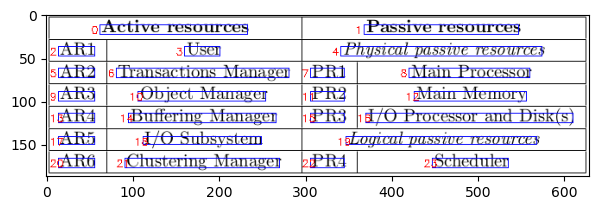

In [73]:
n_rows, n_cols, cells = read_cells(IMG_STRUCT)
cells_updt = update_cells(cells, chunks)

img2 = img.copy()
for cell in cells:
    pos, id = cell['pos'], cell['id']
    left_top = (pos[0], pos[1])
    bottom_right = (pos[2], pos[3])
    # draws rectangle
    cv.rectangle(img2, left_top, bottom_right, (0, 0, 255), 1)
    # shows cell id
    text_pos = (left_top[0] - 10, left_top[1] + 10)
    cv.putText(img2, str(id), text_pos, cv.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

view_img(img2)

In [99]:
class Relation:

    def __init__(self, from_id, to_id, relation, n_blanks):
        self.from_id = from_id
        self.to_id = to_id
        self.relation = relation
        self.n_blanks = n_blanks

    def __repr__(self):
        if self.relation == 1:
            rel = 'horizontal'
        elif self.relation == 2:
            rel = 'vertical'
        else:
            rel = 'undefined'
        return f'From ID: {self.from_id}\n' + \
            f'To ID: {self.to_id}\n' + \
            f"Relation: {rel}\n" + \
            f"Num. blanks between: {self.n_blanks}"

def read_rel(rel_path):
    rels = []
    with open(rel_path, 'r') as f:
        records = f.readlines()
    for r in records:
        vals = r.strip().split('\t')
        from_id, to_id = int(vals[0]), int(vals[1])
        rel_num = vals[2].split(':')
        rel, num = int(rel_num[0]), int(rel_num[1])
        rels.append(Relation(from_id, to_id, rel, num))
    return rels

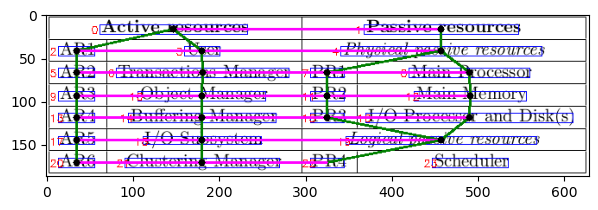

In [122]:
rels = read_rel(IMG_REL)

# note cells have been already sorted by ID as keys so we can just index directly
img3 = img2.copy()
for rel in rels:
    cell_from_pos = cells_updt[rel.from_id]['pos']
    cell_to_pos = cells_updt[rel.to_id]['pos']
    pos_from = (
        int((cell_from_pos[0] + cell_from_pos[2]) / 2),
        int((cell_from_pos[1] + cell_from_pos[3]) / 2)
    )
    pos_to = (
        int((cell_to_pos[0] + cell_to_pos[2]) / 2),
        int((cell_to_pos[1] + cell_to_pos[3]) / 2)
    )
    if rel.relation == 1: 
        color = (255,0,255)
    elif rel.relation == 2: 
        color = (0,127,0)
    else: 
        color = (0,0,0)
    cv.line(img3, pos_from, pos_to, color, 2)
    cv.circle(img3, pos_from, 4, (0,0,0), -1)

view_img(img3)